# (시도) Eearthquake
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연, 최규빈

### imports

In [2]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [3]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

### load data and clean it

`-` load

In [4]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

,Date,Latitude,Longitude,Magnitude
0,01/02/1965,19.2460,145.6160,6.0
1,01/04/1965,1.8630,127.3520,5.8
2,01/05/1965,-20.5790,-173.9720,6.2
3,01/08/1965,-59.0760,-23.5570,5.8
4,01/09/1965,11.9380,126.4270,5.8
...,...,...,...,...
23407,12/28/2016,38.3917,-118.8941,5.6
23408,12/28/2016,38.3777,-118.8957,5.5
23409,12/28/2016,36.9179,140.4262,5.9
23410,12/29/2016,-9.0283,118.6639,6.3


In [5]:
df_korea= pd.read_csv('earthquake_korea2.csv').iloc[:,[1,2,5,6]].rename(columns={'규모':'Magnitude'})

https://www.weather.go.kr/w/eqk-vol/search/korea.do?schOption=&xls=0&startTm=2012-01-02&endTm=2022-06-17&startSize=2&endSize=&startLat=&endLat=&startLon=&endLon=&lat=&lon=&dist=&keyword=&dpType=m

In [6]:
df_global= pd.concat([pd.read_csv('00_05.csv'),pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv'),pd.read_csv('15_20.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

https://www.usgs.gov/programs/earthquake-hazards/lists-maps-and-statistics

`-` cleaning

In [7]:
df.Date[df.Date == '1975-02-23T02:58:41.000Z']

3378    1975-02-23T02:58:41.000Z
Name: Date, dtype: object

In [8]:
df.iloc[3378,0] = '02/03/1975'

In [9]:
df.Date[df.Date == '1985-04-28T02:53:41.530Z']

7512    1985-04-28T02:53:41.530Z
Name: Date, dtype: object

In [10]:
df.iloc[7512,0] = '04/28/1985'

In [11]:
df.Date[df.Date == '2011-03-13T02:23:34.520Z']

20650    2011-03-13T02:23:34.520Z
Name: Date, dtype: object

In [12]:
df.iloc[20650,0] = '03/13/2011'

In [13]:
df= df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).iloc[:,1:]
df

,Latitude,Longitude,Magnitude,Year
0,19.2460,145.6160,6.0,1965
1,1.8630,127.3520,5.8,1965
2,-20.5790,-173.9720,6.2,1965
3,-59.0760,-23.5570,5.8,1965
4,11.9380,126.4270,5.8,1965
...,...,...,...,...
23407,38.3917,-118.8941,5.6,2016
23408,38.3777,-118.8957,5.5,2016
23409,36.9179,140.4262,5.9,2016
23410,-9.0283,118.6639,6.3,2016


In [14]:
df.Year = df.Year.astype(np.float64)

In [15]:
df_korea = df_korea.assign(Year=list(map(lambda x: x.split('/')[0], df_korea.발생시각))).iloc[:,1:]
df_korea = df_korea.assign(Latitude=list(map(lambda x: x.split(' ')[0], df_korea.위도))).iloc[:,[0,2,3,4]]
df_korea = df_korea.assign(Longitude=list(map(lambda x: x.split(' ')[0], df_korea.경도))).iloc[:,[0,2,3,4]]

In [16]:
df_global = df_global.assign(Year=list(map(lambda x: x.split('-')[0], df_global.time))).iloc[:,1:]

In [17]:
df_korea.Year = df_korea.Year.astype(np.float64)
df_korea.Latitude = df_korea.Latitude.astype(np.float64)
df_korea.Longitude = df_korea.Longitude.astype(np.float64)
df_global.Year = df_global.Year.astype(np.float64)

### define class

In [37]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.1,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.6
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visf(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visfhat(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='MagnitudeHat', 
                        radius=15,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visres(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z=[0] * len(self.df), 
                        radius=15,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.7
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [38]:
class MooYaHo2(MooYaHo): # ebayesthresh 기능추가
    def fit2(self,ref=0.5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        self.con = np.where(self.df.Residual>0.7,1,0)
        #plt.plot(self.f,'.')
        #plt.plot(self.fhat,'x')
        fig, axs = plt.subplots(2,2,figsize=(16,10))

        axs[0,0].plot(self.f,'b')
        axs[0,0].set_title('Magnitude')
        axs[0,0].set_ylim([4.5,9])

        axs[0,1].plot(self.fhat,'k')
        axs[0,1].set_title('MagnitudeHat')
        axs[0,1].set_ylim([4.5,9])

        axs[1,0].plot(self.con,'r*')
        axs[1,0].set_title('Residual square')

        axs[1,1].plot(self.f,'b')
        axs[1,1].plot(self.fhat,'k')
        axs[1,1].plot(self.con,'r*')
        axs[1,1].set_title('Graph')
        axs[1,1].set_ylim([4.5,9])

        plt.tight_layout()
        plt.show()

In [39]:
class MooYaHo3(MooYaHo2):
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=37, lon=126), 
                        zoom=5.7,
                        height=900,
                        opacity = 0.3,
                        mapbox_style="stamen-terrain")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.5
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [40]:
       ebayesthresh = importr('EbayesThresh').ebayesthresh

### analysis_df_global(2010~2015)

`-` make instance for analysis

In [41]:
moo_global=MooYaHo2(df_global.query("2010 <= Year < 2015"))

`-` get distance 

In [42]:
moo_global.get_distance()

100%|██████████| 12498/12498 [03:20<00:00, 62.48it/s]  


In [43]:
moo_global.D[moo_global.D>0].mean()

8810.865423093777

(array([14176290., 16005894., 21186674., 22331128., 19394182., 17548252.,
        16668048., 13316436., 12973260.,  2582550.]),
 array([8.97930163e-02, 2.00141141e+03, 4.00273303e+03, 6.00405465e+03,
        8.00537626e+03, 1.00066979e+04, 1.20080195e+04, 1.40093411e+04,
        1.60106627e+04, 1.80119844e+04, 2.00133060e+04]),
 <BarContainer object of 10 artists>)

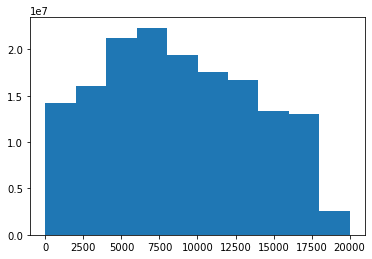

In [44]:
plt.hist(moo_global.D[moo_global.D>0])

`-` weight matrix

In [45]:
moo_global.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

`-` fit

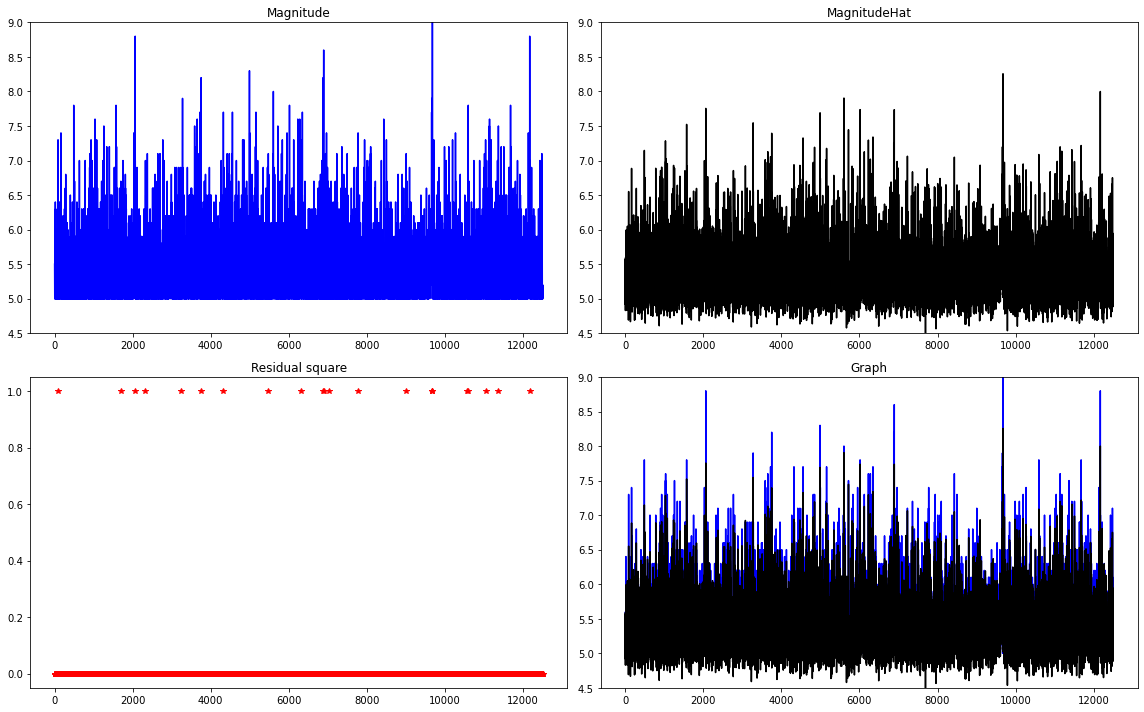

In [46]:
moo_global.fit2()

In [47]:
moo_global.df.sort_values("Residual",ascending=False).iloc[:40,:]

,Latitude,Longitude,Magnitude,Year,MagnitudeHat,Residual
11094,-36.1220,-72.8980,8.8,2010.0,7.754649,1.045351
10727,-36.2170,-73.2570,6.7,2010.0,5.750555,0.949445
27513,0.8020,92.4630,8.2,2012.0,7.253721,0.946279
26109,-10.9280,166.0180,7.1,2013.0,6.194467,0.905533
30291,38.0580,144.5900,7.7,2011.0,6.804163,0.895837
31673,-17.5410,168.0690,7.3,2010.0,6.431399,0.868601
27527,2.3270,93.0630,8.6,2012.0,7.736731,0.863269
30311,38.2970,142.3730,9.1,2011.0,8.255988,0.844012
24388,-19.6097,-70.7691,8.2,2014.0,7.394885,0.805115
28408,-28.9930,-176.2380,7.4,2011.0,6.596810,0.803190


(2010~2014 시도)
- 21번째 Ouest Department, Haiti 아이티 지진 2010년 진도 7.0
- 24번쨰 Puchuncavi, Valparaíso, Chile 칠레 지진 2014년 진도 6.4
- 28번째 Baoxing County, Yaan, Sichuan, China 중국 쓰촨성 지진 2013년 진도 6.6

(2010~2015 시도_결과 좋지 않음?!)
- 23번째 2010년 West New Britain Province, Papua New Guinea 진도 7.3
- 24번째 2011년 Kuzawa Terayama, Tanagura, Higashishirakawa District, Fukushima 963-5671, Japan 진도 6.6
- 29번째 2015년 Kishim, Afghanistan 진도 7.5

`-` vis

In [55]:
#moo_global.visf()

In [54]:
#moo_global.visfhat()

In [53]:
#moo_global.visres()

In [52]:
#moo_global.vis(MagThresh=6.9,ResThresh=0.5)

### analysis_df_global(2015~2020)

`-` make instance for analysis

In [33]:
moo_global=MooYaHo2(df_global.query("2015 <= Year <= 2020"))

`-` get distance 

In [34]:
moo_global.get_distance()

100%|██████████| 11239/11239 [02:44<00:00, 68.51it/s] 


In [35]:
moo_global.D[moo_global.D>0].mean()

8814.318793468068

(array([10894274., 13618924., 16426520., 17583818., 16025000., 15684642.,
        13794372., 10946494.,  9072574.,  2254138.]),
 array([2.54728455e-02, 2.00123511e+03, 4.00244475e+03, 6.00365439e+03,
        8.00486402e+03, 1.00060737e+04, 1.20072833e+04, 1.40084929e+04,
        1.60097026e+04, 1.80109122e+04, 2.00121218e+04]),
 <BarContainer object of 10 artists>)

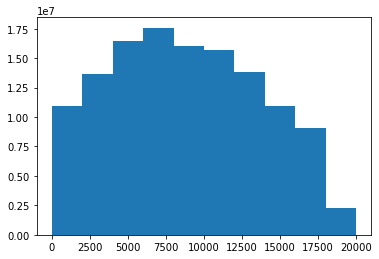

In [36]:
plt.hist(moo_global.D[moo_global.D>0])

`-` weight matrix

In [37]:
moo_global.get_weightmatrix(theta=(8814.318793468068),kappa=2500) 

`-` fit

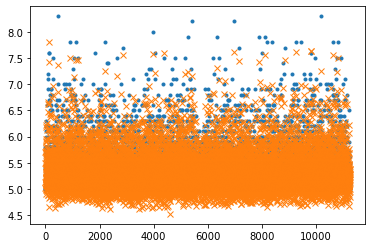

In [38]:
moo_global.fit2()

In [39]:
moo_global.df.sort_values("Residual",ascending=False).iloc[:30,:]

,Latitude,Longitude,Magnitude,Year,MagnitudeHat,Residual
41735,-31.5729,-71.6744,8.3,2015.0,7.247889,1.052111
36993,-18.1125,-178.1530,8.2,2018.0,7.151339,1.048661
21952,-31.5729,-71.6744,8.3,2015.0,7.377015,0.922985
36363,-21.9496,169.4266,7.5,2018.0,6.641801,0.858199
39771,-10.6812,161.3273,7.8,2016.0,6.952781,0.847219
41015,-4.9521,94.3299,7.8,2016.0,6.982741,0.817259
33896,-33.2927,-177.8571,7.4,2020.0,6.584337,0.815663
39932,-42.7373,173.0540,7.8,2016.0,6.994644,0.805356
21719,-8.3381,124.8754,6.5,2015.0,5.698561,0.801439
33404,54.6020,-159.6258,7.6,2020.0,6.825914,0.774086


바다 아닌 거
- 8번째 2016년 Rotherham, New Zealand 뉴질랜드 카이코우라 지진 진도 7.8
- 9번째 2015년 Langkuru Utara, Pureman, Alor Regency, East Nusa Tenggara, Indonesia 수마트라 진도 6.5
- 15번째 2018년 Hela Province, Papua New Guinea 파푸아뉴기니 진도 7.5
- 20번째 2015년 Kalinchok, Nepal 네팧 진도 7.3
- 26번째 2019년 Coquimbo, Chile 칠레 코킴보주 진도 6.7

`-` vis

In [ ]:
#moo_global.vis(MagThresh=7,ResThresh=0.3)

---

In [237]:
pd.read_html('https://en.wikipedia.org/wiki/Lists_of_21st-century_earthquakes',encoding='utf-8')[0].query('Magnitude<=7')# List of deadliest earthquakes

,Rank,Fatalities,Magnitude,Location,Event,Date
1,2,160000,7.0,Haiti,2010 Haiti earthquake,"January 12, 2010"
4,5,26271,6.6,Iran,2003 Bam earthquake,"December 26, 2003"
8,9,5782,6.4,Indonesia,2006 Yogyakarta earthquake,"May 26, 2006"
10,11,2968,6.9,China,2010 Yushu earthquake,"April 13, 2010"
11,12,2266,6.8,Algeria,2003 Boumerdès earthquake,"May 21, 2003"
14,15,1143,5.9,Afghanistan,June 2022 Afghanistan earthquake,"June 21, 2022"


In [271]:
pd.read_html('https://en.wikipedia.org/wiki/Lists_of_21st-century_earthquakes',encoding='utf-8')[3] # Deadliest earthquakes by year

,Year,Fatalities,Magnitude,Event,Location,Date,Death toll
0,2001,20085,7.7,2001 Gujarat earthquake,India,January 26,21357
1,2002,1000,6.1,2002 Hindu Kush earthquakes,Afghanistan,March 25,1685
2,2003,26271,6.6,2003 Bam earthquake,Iran,December 26,33819
3,2004,227898,9.1,2004 Indian Ocean earthquake and tsunami,"Indonesia, Indian Ocean",December 26,227898
4,2005,87351,7.6,2005 Kashmir earthquake,Pakistan,October 8,87992
5,2006,5782,6.4,2006 Yogyakarta earthquake,Indonesia,May 26,6605
6,2007,519,8.0,2007 Peru earthquake,Peru,August 15,708
7,2008,87587,7.9,2008 Sichuan earthquake,China,May 12,88708
8,2009,1115,7.6,2009 Sumatra earthquakes,Indonesia,September 30,1790
9,2010,160000,7.0,2010 Haiti earthquake,Haiti,January 12,164627
